We start by loading the libraries and the Data :
We are going to use CNN ResNet50, which explain the use of the library keras.  

In [1]:
import numpy as np # linear algebra
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import os
import shutil
import multiprocessing as mp
import tensorflow as tf

from random import randint
import cv2
import numpy as np
import sklearn.metrics as metrics
from keras.models import load_model
from keras.models import Sequential
from keras import optimizers
from keras.utils import to_categorical
from sklearn.utils import class_weight
from keras import layers
from keras.layers import Dense, Dropout, Activation, GlobalAveragePooling2D, MaxPooling2D, Conv2D, Input, Flatten
#from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.models import Model
from keras.initializers import RandomNormal
from keras.optimizers import SGD



from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.preprocessing import image
#from keras.applications.resnet50 import ResNet50

%matplotlib inline

train_dir = '/kaggle/input/food11/training'
test_dir = '/kaggle/input/food11/validation'

train_files = [f for f in os.listdir(train_dir) if os.path.isfile(os.path.join(train_dir, f))]
test_files = [f for f in os.listdir(test_dir) if os.path.isfile(os.path.join(test_dir, f))]

Using TensorFlow backend.


Here we are going to extract the labels and the names of the file names from training and validation set.

In [2]:
from scipy import ndimage
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img

# label extraction
train = []
y_train = []
test = []
y_test = []

for file in train_files:
    train.append(file)
    label= file.find("_")
    y_train.append(int(file[0:label]))
for file in test_files:
    test.append(file)
    label= file.find("_")
    y_test.append(int(file[0:label]))

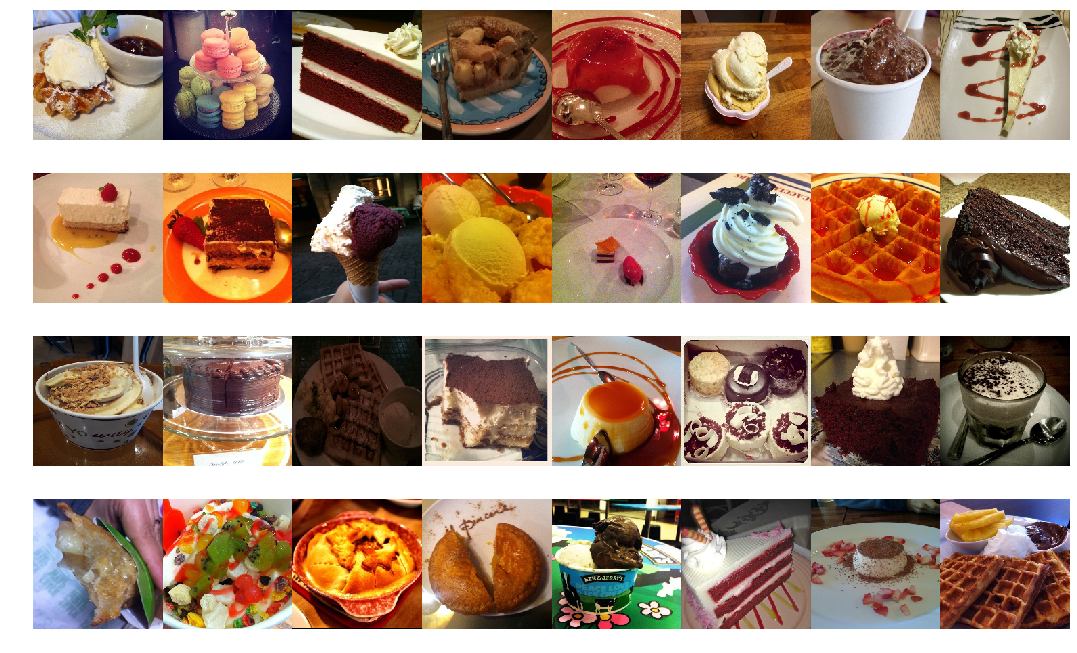

In [3]:

def Random_sample_images(n_class=0):
    nrows = 4
    ncols = 8
    fig, axes = plt.subplots(nrows=nrows,ncols = ncols)
    fig.set_size_inches(16,12)
    img = np.random.choice((np.array(y_train) == n_class).nonzero()[0],nrows*ncols)
    for i,ax in enumerate(axes.flat):
        image = cv2.imread(train_dir + "/" + train[img[i]]) 
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, dsize=(192, 192), interpolation=cv2.INTER_CUBIC)
        im = ax.imshow(image)
        ax.set_axis_off() #to remove the axis
    plt.subplots_adjust(left = 0,wspace = 0,hspace = 0)
    plt.show()
    
    
Random_sample_images(2)

* We create containers where we store the arrays of the images in the shape (192,192,3)for both training and validation data.
* We loaded images with PIL library.
* We chose 192 because of lack of RAM and kernel crashing

In [4]:
cnnInput = np.ndarray(shape=(len(train), 192,192, 3), dtype=np.float32)
print('[INFO] Loading training images')
i=0
for file in train:
    image = cv2.imread(train_dir + "/" + file)  
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # do not normalize for this model, keep 0-255
    image = image.astype("float")
    image = cv2.resize(image, dsize=(192, 192), interpolation=cv2.INTER_CUBIC)
    # no normalization for this model, keep 0-255
    x = img_to_array(image)
    x = x.reshape((1, x.shape[0], x.shape[1],
                                   x.shape[2]))

    cnnInput[i]=x
    i+=1
print('[INFO] Done')

[INFO] Loading training images
[INFO] Done


In [5]:
cnnTest = np.ndarray(shape=(len(test), 192,192, 3), dtype=np.float32)
print('[INFO] Loading test images')
i=0
for file in test:
    image = cv2.imread(test_dir + "/" + file)  
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # do not normalize for this model, keep 0-255
    image = image.astype("float")
    image = cv2.resize(image, dsize=(192, 192))
    # no normalization for this model, keep 0-255
    x = img_to_array(image)
    x = x.reshape((1, x.shape[0], x.shape[1],
                                   x.shape[2]))

    cnnTest[i]=x
    i+=1
print('[INFO] Done')

[INFO] Loading test images
[INFO] Done


We used one hot encoding instead of number of the class for labels. To get an ouput of probabilities for belonging to each class.

In [6]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import warnings
from keras import backend as K
from keras import layers as L
from keras import models as M
from keras import utils as U
WEIGHTS_PATH = ('https://github.com/fchollet/deep-learning-models/'
                'releases/download/v0.2/'
                'resnet50_weights_tf_dim_ordering_tf_kernels.h5')
WEIGHTS_PATH_NO_TOP = ('https://github.com/fchollet/deep-learning-models/'
                       'releases/download/v0.2/'
                       'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')

backend = None
layers = None
models = None
keras_utils = None
_KERAS_BACKEND = None
_KERAS_LAYERS = None
_KERAS_MODELS = None
_KERAS_UTILS = None


def get_submodules_from_kwargs(kwargs):
    backend = kwargs.get('backend', _KERAS_BACKEND)
    layers = kwargs.get('layers', _KERAS_LAYERS)
    models = kwargs.get('models', _KERAS_MODELS)
    utils = kwargs.get('utils', _KERAS_UTILS)
    for key in kwargs.keys():
        if key not in ['backend', 'layers', 'models', 'utils']:
            raise TypeError('Invalid keyword argument: %s', key)
    return backend, layers, models, utils
CLASS_INDEX = None
CLASS_INDEX_PATH = ('https://storage.googleapis.com/download.tensorflow.org/'
                    'data/imagenet_class_index.json')

def preprocess_input(x, data_format=None, mode='caffe', **kwargs):
    backend, _, _, _ = get_submodules_from_kwargs(kwargs)

    if data_format is None:
        data_format = backend.image_data_format()
    if data_format not in {'channels_first', 'channels_last'}:
        raise ValueError('Unknown data_format ' + str(data_format))

    if isinstance(x, np.ndarray):
        return _preprocess_numpy_input(x, data_format=data_format,
                                       mode=mode, **kwargs)
    else:
        return _preprocess_symbolic_input(x, data_format=data_format,
                                          mode=mode, **kwargs)
def decode_predictions(preds, top=5, **kwargs):
    global CLASS_INDEX

    backend, _, _, keras_utils = get_submodules_from_kwargs(kwargs)

    if len(preds.shape) != 2 or preds.shape[1] != 1000:
        raise ValueError('`decode_predictions` expects '
                         'a batch of predictions '
                         '(i.e. a 2D array of shape (samples, 1000)). '
                         'Found array with shape: ' + str(preds.shape))
    if CLASS_INDEX is None:
        fpath = keras_utils.get_file(
            'imagenet_class_index.json',
            CLASS_INDEX_PATH,
            cache_subdir='models',
            file_hash='c2c37ea517e94d9795004a39431a14cb')
        with open(fpath) as f:
            CLASS_INDEX = json.load(f)
    results = []
    for pred in preds:
        top_indices = pred.argsort()[-top:][::-1]
        result = [tuple(CLASS_INDEX[str(i)]) + (pred[i],) for i in top_indices]
        result.sort(key=lambda x: x[2], reverse=True)
        results.append(result)
    return results


def _obtain_input_shape(input_shape,default_size,min_size,data_format,require_flatten,weights=None):
    if weights != 'imagenet' and input_shape and len(input_shape) == 3:
        if data_format == 'channels_first':
            if input_shape[0] not in {1, 3}:
                warnings.warn(
                    'This model usually expects 1 or 3 input channels. '
                    'However, it was passed an input_shape with ' +
                    str(input_shape[0]) + ' input channels.')
            default_shape = (input_shape[0], default_size, default_size)
        else:
            if input_shape[-1] not in {1, 3}:
                warnings.warn(
                    'This model usually expects 1 or 3 input channels. '
                    'However, it was passed an input_shape with ' +
                    str(input_shape[-1]) + ' input channels.')
            default_shape = (default_size, default_size, input_shape[-1])
    else:
        if data_format == 'channels_first':
            default_shape = (3, default_size, default_size)
        else:
            default_shape = (default_size, default_size, 3)
    if weights == 'imagenet' and require_flatten:
        if input_shape is not None:
            if input_shape != default_shape:
                raise ValueError('When setting `include_top=True` '
                                 'and loading `imagenet` weights, '
                                 '`input_shape` should be ' +
                                 str(default_shape) + '.')
        return default_shape
    if input_shape:
        if data_format == 'channels_first':
            if input_shape is not None:
                if len(input_shape) != 3:
                    raise ValueError(
                        '`input_shape` must be a tuple of three integers.')
                if input_shape[0] != 3 and weights == 'imagenet':
                    raise ValueError('The input must have 3 channels; got '
                                     '`input_shape=' + str(input_shape) + '`')
                if ((input_shape[1] is not None and input_shape[1] < min_size) or
                   (input_shape[2] is not None and input_shape[2] < min_size)):
                    raise ValueError('Input size must be at least ' +
                                     str(min_size) + 'x' + str(min_size) +
                                     '; got `input_shape=' +
                                     str(input_shape) + '`')
        else:
            if input_shape is not None:
                if len(input_shape) != 3:
                    raise ValueError(
                        '`input_shape` must be a tuple of three integers.')
                if input_shape[-1] != 3 and weights == 'imagenet':
                    raise ValueError('The input must have 3 channels; got '
                                     '`input_shape=' + str(input_shape) + '`')
                if ((input_shape[0] is not None and input_shape[0] < min_size) or
                   (input_shape[1] is not None and input_shape[1] < min_size)):
                    raise ValueError('Input size must be at least ' +
                                     str(min_size) + 'x' + str(min_size) +
                                     '; got `input_shape=' +
                                     str(input_shape) + '`')
    else:
        if require_flatten:
            input_shape = default_shape
        else:
            if data_format == 'channels_first':
                input_shape = (3, None, None)
            else:
                input_shape = (None, None, 3)
    if require_flatten:
        if None in input_shape:
            raise ValueError('If `include_top` is True, '
                             'you should specify a static `input_shape`. '
                             'Got `input_shape=' + str(input_shape) + '`')
    return input_shape
def identity_block(input_tensor, kernel_size, filters, stage, block):
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = L.Conv2D(filters1, (1, 1),
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2a')(input_tensor)
    x = L.BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = L.Activation('relu')(x)

    x = L.Conv2D(filters2, kernel_size,
                      padding='same',
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2b')(x)
    x = L.BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = L.Activation('relu')(x)

    x = L.Conv2D(filters3, (1, 1),
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2c')(x)
    x = L.BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = L.add([x, input_tensor])
    x = L.Activation('relu')(x)
    return x


def conv_block(input_tensor,kernel_size,filters,stage,block,strides=(2, 2)):
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = L.Conv2D(filters1, (1, 1), strides=strides,
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2a')(input_tensor)
    x = L.BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = L.Activation('relu')(x)

    x = L.Conv2D(filters2, kernel_size, padding='same',
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2b')(x)
    x = L.BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = L.Activation('relu')(x)

    x = L.Conv2D(filters3, (1, 1),
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2c')(x)
    x = L.BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = L.Conv2D(filters3, (1, 1), strides=strides,
                             kernel_initializer='he_normal',
                             name=conv_name_base + '1')(input_tensor)
    shortcut = L.BatchNormalization(
        axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = L.add([x, shortcut])
    x = L.Activation('relu')(x)
    return x


def ResNet50(include_top=True,weights='imagenet',input_tensor=None,input_shape=None,pooling=None,classes=1000,**kwargs):
    global backend, layers, models, keras_utils
    backend, layers, models, keras_utils = get_submodules_from_kwargs(kwargs)

    if not (weights in {'imagenet', None} or os.path.exists(weights)):
        raise ValueError('The `weights` argument should be either '
                         '`None` (random initialization), `imagenet` '
                         '(pre-training on ImageNet), '
                         'or the path to the weights file to be loaded.')

    if weights == 'imagenet' and include_top and classes != 1000:
        raise ValueError('If using `weights` as `"imagenet"` with `include_top`'
                         ' as true, `classes` should be 1000')

    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=32,
                                      data_format=K.image_data_format(),
                                      require_flatten=include_top,
                                      weights=weights)

    if input_tensor is None:
        img_input = L.Input(shape=input_shape)
    else:
        if not backend.is_keras_tensor(input_tensor):
            img_input = L.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1

    x = L.ZeroPadding2D(padding=(3, 3), name='conv1_pad')(img_input)
    x = L.Conv2D(64, (7, 7),
                      strides=(2, 2),
                      padding='valid',
                      kernel_initializer='he_normal',
                      name='conv1')(x)
    x = L.BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = L.Activation('relu')(x)
    x = L.ZeroPadding2D(padding=(1, 1), name='pool1_pad')(x)
    x = L.MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')

    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')

    if include_top:
        x = L.GlobalAveragePooling2D(name='avg_pool')(x)
        x = L.Dense(classes, activation='softmax', name='fc1000')(x)
    else:
        if pooling == 'avg':
            x = L.GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = L.GlobalMaxPooling2D()(x)
        else:
            warnings.warn('The output shape of `ResNet50(include_top=False)` '
                          'has been changed since Keras 2.2.0.')

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = keras_utils.get_source_inputs(input_tensor)
    else:
        inputs = img_input
    # Create model.
    model = M.Model(inputs, x, name='resnet50')

    # Load weights.
    if weights == 'imagenet':
        if include_top:
            weights_path = U.get_file(
                'resnet50_weights_tf_dim_ordering_tf_kernels.h5',
                WEIGHTS_PATH,
                cache_subdir='models',
                md5_hash='a7b3fe01876f51b976af0dea6bc144eb')
        else:
            weights_path = U.get_file(
                'resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                WEIGHTS_PATH_NO_TOP,
                cache_subdir='models',
                md5_hash='a268eb855778b3df3c7506639542a6af')
        model.load_weights(weights_path)
        if K.backend() == 'theano':
            U.convert_all_kernels_in_model(model)
    elif weights is not None:
        model.load_weights(weights)

    return model

In [7]:
model = ResNet50(weights='imagenet',include_top=False,input_shape=(192,192,3),classes=11)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:297: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.


94658560/94653016 [==============================] - 1s 0us/step


In [8]:
# make explained variable hot-encoded
y_train_hot_encoded = to_categorical(y_train)
y_test_hot_encoded = to_categorical(y_test)

In [9]:
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)

In [10]:
# get layers and add average pooling layer
x = model.output
x = GlobalAveragePooling2D()(x)

# add fully-connected layer
x = Dense(2048, activation='relu')(x)
x = Dropout(0.3)(x)

# add output layer
predictions = Dense(11, activation='softmax')(x)

model = Model(inputs=model.input, outputs=predictions)

# training
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
history= model.fit(cnnInput,y_train_hot_encoded, batch_size=64, shuffle=True,
                    validation_data=(cnnTest, y_test_hot_encoded),
                  class_weight=class_weights, epochs=60)
#history = model.fit(cnnInput, y_train_hot_encoded, batch_size=256, epochs=50, shuffle=True,  validation_split=0.1)

Train on 9866 samples, validate on 3430 samples
Epoch 1/60
9866/9866 [==============================] - 110s 11ms/step - loss: 2.1600 - accuracy: 0.2670 - val_loss: 1.7294 - val_accuracy: 0.4300
Epoch 2/60
9866/9866 [==============================] - 84s 8ms/step - loss: 1.5735 - accuracy: 0.4955 - val_loss: 1.3459 - val_accuracy: 0.5889
Epoch 3/60
9866/9866 [==============================] - 84s 8ms/step - loss: 1.2429 - accuracy: 0.6159 - val_loss: 1.1113 - val_accuracy: 0.6586
Epoch 4/60
9866/9866 [==============================] - 84s 8ms/step - loss: 1.0229 - accuracy: 0.6848 - val_loss: 0.9601 - val_accuracy: 0.7047
Epoch 5/60
9866/9866 [==============================] - 84s 8ms/step - loss: 0.8704 - accuracy: 0.7297 - val_loss: 0.8490 - val_accuracy: 0.7431
Epoch 6/60
9866/9866 [==============================] - 84s 8ms/step - loss: 0.7577 - accuracy: 0.7658 - val_loss: 0.7792 - val_accuracy: 0.7644
Epoch 7/60
9866/9866 [==============================] - 84s 8ms/step - loss: 0.6

In [11]:
#to save the model
#model.save('Food11_60Epoch.h5')

In [12]:
#to load the model
#history = load_model("Food11_60Epoch.h5")

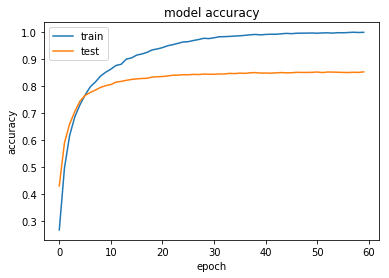

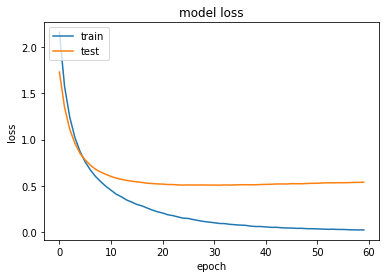

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [14]:
# training
#history = model.fit(cnnInput, y_train_hot_encoded, batch_size=256, epochs=50, shuffle=True,  validation_split=0.1)
data_dict = {0:"Bread is a staple food prepared from a dough of flour and water,#usually by baking.Throughout recorded history it has been a prominent #food in large parts of the world;#it is one of the oldest man-made foods,#having been of significant importance since the dawn of agriculture; and #plays an essential role in religious rituals and secular culture.Bread may be leavened by #naturally occurring microbes, chemicals, industrially produced yeast, or high-pressure aeration.#In many countries, commercial bread often contains additives to improve flavor, texture, color, shelf life, nutrition, and ease of production for one slice(32gms)#Calories 82#Fat 1.1g#Sodium 144mg#Carbohydrates 13.8g#Fiber 1.9g#Sugars 1.4g#Protein 4g",
1 : "Dairy products or milk products are a type of food produced from or containing the milk of mammals.#They are primarily produced from mammals such as cattle, water buffaloes, goats, sheep, camels and humans. Dairy products include food items such as yogurt, cheese and butter.A facility that produces dairy products is known as a dairy, or dairy factory.Dairy products are consumed worldwide, with the exception of most of East and Southeast Asia and parts of central Africa. #Amount Per 100 grams#Calories 46#Total Fat 2 g#Sodium 55 mg#Potassium 150 mg#Total Carbohydrate 5 g#fiber 0 g#Sugar 5g#Protein 1.6 g",
2 : "Desert is usually a sweet course or dish (as of pastry or ice cream) usually served at the end of a meal. 2 British : a fresh fruit served after a sweet course.Amount Per 100 grams#Calories 20#Total Fat 11 g#Sodium 80 mg#Potassium 199 mg#Total Carbohydrate 24 g#fiber 0.7 g#Sugar 21 g#Protein 3.5 g",
3 : "Egg yolks and whole eggs store significant amounts of protein and choline,and are widely used in cookery. Due to their protein content, the United States Department of Agriculture formerly categorized eggs as Meats within the Food Guide Pyramid (now MyPlate). Despite the nutritional value of eggs, there are some potential health issues arising from cholesterol content, salmonella contamination, and allergy to egg proteins.Amount Per 100 grams#Calories 155#Total Fat 11 g#Sodium 124 mg#Potassium 126 mg#Total Carbohydrate 1.1 g#fiber 0g#Sugar 1.1 g#Protein 13 g",
4 : "Deep frying is a common cooking method used across the globe. It’s often used by restaurants and fast food chains as a quick and inexpensive way to prepare foods. Popular fried foods include fish, french fries, chicken strips and cheese sticks, although you can deep fry just about anything. Many people like the taste of fried foods. Yet these foods tend to be high in calories and trans fat, so eating a lot of them can have negative effects on your health.#Amount Per 100 grams#Calories 200#Total Fat 1 g#Potassium 0 mg#Total Carbohydrate 39 g#fiber 4 g#Sugar 4g#Protein 7 g",
5 : "Meat is animal flesh that is eaten as food.Humans have hunted and killed animals for meat since prehistoric times. The advent of civilization allowed the domestication of animals such as chickens, sheep, rabbits, pigs and cattle. This eventually led to their use in meat production on an industrial scale with the aid of slaughterhouses. Meat is mainly composed of water, protein, and fat. It is edible raw, but is normally eaten after it has been cooked and seasoned or processed in a variety of ways. Unprocessed meat will spoil or rot within hours or days as a result of infection with and decomposition by bacteria and fungi.Meat is important in economy and culture, even though its mass production and consumption has been determined to pose risks for human health and the environment. Many religions have rules about which meat may or may not be eaten. Vegetarians and vegans may abstain from eating meat because of concerns about the ethics of eating meat, environmental effects of meat production or nutritional effects of consumption.#Amount Per 100 grams#Calories 143#Total Fat 3.5 g#Sodium 57 mg#Potassium 421 mg#Total Carbohydrate 0 g#fiber 0g#Sugar 0 g#Protein 26 g",
6 : "Noodles and pasta differ primarily because of their ingredients and the type of processing involved, Kaminska says. Noodles are usually made with flour milled from common wheat. Pasta is processed from durum semolina, which is coarser than typical flour. However, that difference is not always so cut and dried. In some markets, processors will use common wheat for pasta because durum is so expensive. But in a higher-end market such as Italy, there are regulations that require pasta to be made of 100 per cent durum.Also, certain markets such as Japan are starting to use durum in fresh alkaline noodles because they like the yellow colour that the flour provides.There are many formulas for making a variety of Asian noodles, but salt is always a requirement in the production phase. Noodles undergo a “sheeting” process where dough is passed through a series of rollers to produce a flat sheet that is sent through a cutter to produce individual noodle strands. Pasta, on the other hand, involves mixing durum semolina with water to form a stiff dough which is then extruded through a mould or die to create various shapes such as spaghetti, lasagna or macaroni.#Amount Per 100grams#Calories 131#Total Fat 1.1 g#Sodium 6 mg#Potassium 24 mg#Total Carbohydrate 25 g#fiber 0g#sugar 0g#Protein 5 g",
7 : "Rice, a monocot, is normally grown as an annual plant, although in tropical areas it can survive as a perennial and can produce a ratoon crop for up to 30 years.Rice cultivation is well-suited to countries and regions with low labor costs and high rainfall, as it is labor-intensive to cultivate and requires sample water. However, rice can be grown practically anywhere, even on a steep hill or mountain area with the use of water-controlling terrace systems. Although its parent species are native to Asia and certain parts of Africa, centuries of trade and exportation have made it commonplace in many cultures worldwide.Amount Per 100 grams#Calories 111#Total Fat 0.9 g#Sodium 5 mg#Potassium 43 mg#Total Carbohydrate 23 g#fiber 1.8 g#Sugar 0.4 g#Protein 2.6 g",
8 : "The harvesting of wild seafood is usually known as fishing or hunting, while the cultivation and farming of seafood is known as aquaculture or fish farming(in the case of fish). Seafood is often colloquially distinguished from meat, although it is still animal in nature and is excluded from a vegetarian diet, as decided by groups like the Vegetarian Society after confusion surrounding pescetarianism. Seafood is an important source of (animal) protein in many diets around the world, especially in coastal areas.#Amount Per 100 grams#Calories 204#Total Fat 8 g#Sodium 117 mg#Potassium 283 mg#Total Carbohydrate 1.9 g#fiber 0 g#Protein 29 g",
9 : "Soup(food) is low in Saturated Fat, and very low in Cholesterol. It is also a good source of Dietary Fiber, Vitamin E (Alpha Tocopherol), Thiamin, Niacin, Vitamin B6, Potassium, Copper and Manganese, and a very good source of Vitamin A.#amount 100gms#Calories 65#Total Fat 0.9g#Sodium 385mg#Potassium 433mg#Carbohydrates 12.1g#Sugar 4.3g#Fiber 2.1g#Protein 2.2g",
10: "Vegetables are parts of plants that are consumed by humans or other animals as food. The original meaning is still commonly used and is applied to plants collectively to refer to all edible plant matter, including the flowers, fruits, stems, leaves, roots, and seeds. The alternate definition of the term is applied somewhat arbitrarily, often by culinary and cultural tradition. It may exclude foods derived from some plants that are fruits, flowers, nuts, and cereal grains, but include savoury fruits such as tomatoes and courgettes, flowers such as broccoli, and seeds such as pulses.#Amount Per 100 grams#Calories 52#Total Fat 0.2 g#Sodium 1 mg#Potassium 107 mg#Total Carbohydrate 14 g#fiber 2.4 g#Sugar 10 g#Protein 0.3 g"}
 

The test image is: 836 in test images

Shape of the image is: (192, 192, 3)

Original class is: 10

Predicted class is: 10
Vegetables are parts of plants that are consumed by humans or other animals as food. The original meaning is still commonly used and is applied to plants collectively to refer to all edible plant matter, including the flowers, fruits, stems, leaves, roots, and seeds. The alternate definition of the term is applied somewhat arbitrarily, often by culinary and cultural tradition. It may exclude foods derived from some plants that are fruits, flowers, nuts, and cereal grains, but include savoury fruits such as tomatoes and courgettes, flowers such as broccoli, and seeds such as pulses.
Amount Per 100 grams
Calories 52
Total Fat 0.2 g
Sodium 1 mg
Potassium 107 mg
Total Carbohydrate 14 g
fiber 2.4 g
Sugar 10 g
Protein 0.3 g


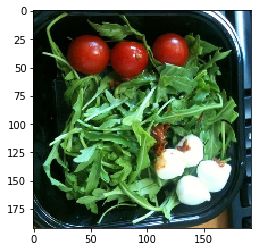

In [15]:
#Predicting a image
rand_num = randint(0,3430)
test_image = cv2.imread(train_dir + "/" + test[rand_num]) 
test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
test_image = cv2.resize(test_image, dsize=(192, 192), interpolation=cv2.INTER_CUBIC)
im = imshow(test_image)
predict_image = np.expand_dims(test_image, axis = 0)
#predict_image = preprocess_input(predict_image)
print("The test image is: " + str(rand_num) + ' in test images')
print("\nShape of the image is: " + str(test_image.shape))

probability_list = model.predict(predict_image)
#print(probability_list)
max_value = max(probability_list[0])
duplicate_list = list(probability_list[0])
index = duplicate_list.index(max_value)
print('\nOriginal class is: ' + str(y_test[rand_num]))
print('\nPredicted class is: '+ str(index))
nutrients = data_dict[index]
nutrients_list = nutrients.split('#')
for each in nutrients_list:
    print(each)

In [16]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 192, 192, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 198, 198, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 96, 96, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 96, 96, 64)   256         conv1[0][0]                      
____________________________________________________________________________________________

In [17]:
#Extra Other Technique

In this part, we did data augmentation. Data augmentation is a way of creating new data with modifications:

* different orientations (horizontal_flip and vertical_flip)
* With shift (randomly shift images horizontally or randomly shift images vertically)
* Zoom We used this image generator for training and validation, but for validation image generator, we use the original images from validation dataset.

In [18]:
# Data augmentation
#from keras.preprocessing.image import ImageDataGenerator
# this is the augmentation configuration we will use for training
#train_datagen = ImageDataGenerator(
#    width_shift_range=0.2,
#    height_shift_range=0.2,
#    zoom_range=[.6, 1],
#    vertical_flip=True,
#    horizontal_flip=True)
#train_generator = train_datagen.flow(cnnInput, y_train, batch_size=64, seed=11)
#test_datagen = ImageDataGenerator()
#test_generator = valid_datagen.flow(cnnValidation, y_valid, batch_size=64, seed=11)

In [19]:
#train_datagen.fit(cnnInput)
#test_datagen.fit(cnnTest)

In [20]:
#model.fit_generator(train_datagen.flow(cnnInput, y_train_hot_encoded, batch_size=64), shuffle=True,validation_data=valid_datagen.flow(cnnValidation, y_test_hot_encoded, batch_size=64),class_weight=class_weights, epochs=20)